# Turning Back Time
## A simple ML approach to infer Parameters about the material of the staircase and its usage from stair contours

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import (
    mean_squared_error, r2_score,
    accuracy_score, confusion_matrix, classification_report
)

In [3]:
# Simulate data
np.random.seed(42)
num_samples = 500
height, width = 10, 10
X_matrices = np.random.rand(num_samples, height, width)  # 2D surfaces
X = X_matrices.reshape(num_samples, -1)  # Flatten to (num_samples, 100)

# Create 9 continuous targets (multi-output regression)
Y_reg = np.zeros((num_samples, 9))
for i in range(9):
    Y_reg[:, i] = X.sum(axis=1) * (i+1) + np.random.normal(scale=0.1, size=num_samples)

# Create 1 binary target for classification
threshold = np.median(X.sum(axis=1))
Y_class = (X.sum(axis=1) > threshold).astype(int)

# Split data
X_train, X_test, Y_reg_train, Y_reg_test, Y_class_train, Y_class_test = train_test_split(
    X, Y_reg, Y_class, test_size=0.2, random_state=42
)

## Regression on outputs excluding social convention (left/right)

In [4]:
# Multi-output regression with Random Forest
regressor = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
regressor.fit(X_train, Y_reg_train)
Y_reg_pred = regressor.predict(X_test)

# Compute MSE and R² for each of the 9 regression outputs
mse_vals = mean_squared_error(Y_reg_test, Y_reg_pred, multioutput='raw_values')
r2_vals = r2_score(Y_reg_test, Y_reg_pred, multioutput='raw_values')
print("=== Multi-Output Regression Metrics ===")
for i in range(9):
    print(f"Target {i+1}: MSE={mse_vals[i]:.4f}, R²={r2_vals[i]:.4f}")
print()

=== Multi-Output Regression Metrics ===
Target 1: MSE=7.0001, R²=0.1260
Target 2: MSE=27.5501, R²=0.1255
Target 3: MSE=61.8679, R²=0.1258
Target 4: MSE=110.5213, R²=0.1245
Target 5: MSE=172.7032, R²=0.1243
Target 6: MSE=248.1720, R²=0.1246
Target 7: MSE=337.7444, R²=0.1249
Target 8: MSE=441.5338, R²=0.1247
Target 9: MSE=559.0350, R²=0.1250



## Classification on social convention

In [5]:
# Random Forest classification
classifier = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# 5-fold cross validation on training set
cv_scores = cross_val_score(classifier, X_train, Y_class_train, cv=5, scoring='accuracy')
print("=== 5-Fold CV Accuracy (Training set) ===")
print(f"Mean={cv_scores.mean():.4f}, Std={cv_scores.std():.4f}")
print()

# Fit on full training set and evaluate on test set
classifier.fit(X_train, Y_class_train)
Y_class_pred = classifier.predict(X_test)
acc = accuracy_score(Y_class_test, Y_class_pred)
print("=== Classification on Test Set ===")
print(f"Accuracy: {acc:.4f}")
print(classification_report(Y_class_test, Y_class_pred, target_names=['Left', 'Right']))
print()

=== 5-Fold CV Accuracy (Training set) ===
Mean=0.6800, Std=0.0367

=== Classification on Test Set ===
Accuracy: 0.7000
              precision    recall  f1-score   support

        Left       0.83      0.63      0.72        60
       Right       0.59      0.80      0.68        40

    accuracy                           0.70       100
   macro avg       0.71      0.72      0.70       100
weighted avg       0.73      0.70      0.70       100




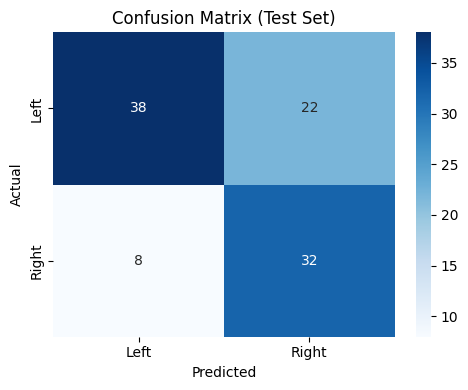

In [6]:
# Confusion matrix 
cm = confusion_matrix(Y_class_test, Y_class_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=['Left','Right'], yticklabels=['Left','Right'])
plt.title("Confusion Matrix (Test Set)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

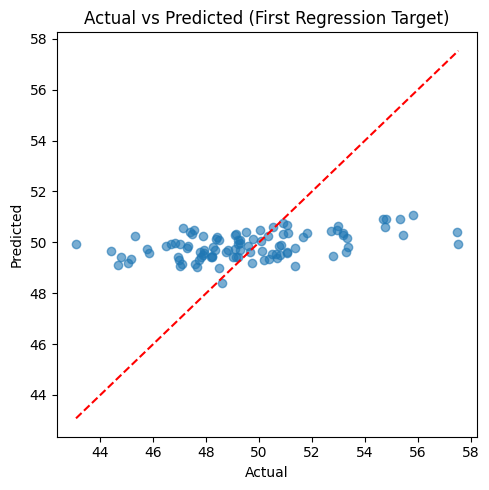

In [7]:
# Scatter plot 
plt.figure(figsize=(5,5))
plt.scatter(Y_reg_test[:, 0], Y_reg_pred[:, 0], alpha=0.6)
plt.plot([Y_reg_test[:, 0].min(), Y_reg_test[:, 0].max()],
         [Y_reg_test[:, 0].min(), Y_reg_test[:, 0].max()],
         color='red', linestyle='--')
plt.title("Actual vs Predicted (First Regression Target)")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.tight_layout()
plt.show()